<a href="https://colab.research.google.com/github/SteffiJF/wine-specialization-project/blob/main/DifferencingAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Further experimenting on indexing, removing duplicates, and differencing data, looking at specific districts

In [15]:
!pip install "dask[dataframe]" #Needs to be installed every time, not sure why

import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import numpy as np
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials	
from datetime import datetime
%matplotlib inline
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from math import sqrt
from matplotlib import pyplot
from numpy import array
from google.colab import drive
import seaborn as sns
import matplotlib._color_data as mcd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 6)})


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Downloading data from Google Disk (you need to upload the files into your own Google Disk and update to your own id or choose an alternative method to load data)

In [3]:
#Settting up connection to Google Disk
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Downloading sales data
download = drive.CreateFile({'id': '16d4KjwOcHkZJaBp4C1w1PhFHuInIRuu3'}) 
download.GetContentFile('Salg.csv')
sales = pd.read_csv("Salg.csv", sep=';',  parse_dates = [['År', 'Måned']], low_memory=False)

#Downloading ranking data
download2 = drive.CreateFile({'id': '1rtnYjvN7q8reK-RCX3H_7qVYW_837t9J'}) 
download2.GetContentFile('Rangering.csv')
ranks = pd.read_csv("Rangering.csv", sep=';',  parse_dates = [['År', 'Måned']], low_memory=False)

#Downloading product data
download3 = drive.CreateFile({'id': '1s8afH0Xt_YqCpMvCuWkUeI9T0RJVuT32'}) 
download3.GetContentFile('Products.csv')
products = pd.read_csv("Products.csv", sep=';', low_memory=False)


Setting up data for modeling

In [5]:
#Selecting area and features to study

country = 'ITA'  
district = 'PIE' 
product = 'Rødvin'
packaging = 'Engangsflaske av glass'

###############################################################################

# Merging files into single dataframe
def merging(sales, ranks, products, country, district, product, packaging):

  #Removing irrelevant areas
  chosenSales = sales[sales['Land']==country]
  chosenSales = chosenSales[chosenSales['Distrikt']==district]
  chosenSales = chosenSales[chosenSales['Varetype']==product]

  #Changing column names to match data frames
  products = products.rename(columns={"VMP ID": "Artikkelnr", "Alkohol %": "Alkoholprosent"})

  #Keeping interesting columns
  smallSales = chosenSales[['År_Måned','Artikkelnr','Liter denne måned i år', 'Salgspris', 'Årgang', 'Volum', 'Alkoholprosent', 'Utvalg']]
  smallRanks = ranks[['År_Måned','Artikkelnr', 'Rangering', 'Status',	'Styringstall']]
  smallProducts = products[['Artikkelnr', 'Årgang', 'Alkoholprosent', 'Emballasjetype']]

  #Converting to dask dataframe for merging
  dfSales = dd.from_pandas(smallSales, npartitions=10)
  dfRanks = dd.from_pandas(smallRanks, npartitions=10)
  dfProducts = dd.from_pandas(smallProducts, npartitions=10)

  # Merge the csv files.
  df = dd.merge(dfSales, dfRanks, how='left', on=['Artikkelnr', 'År_Måned'])
  df = dd.merge(df, dfProducts, how='left', on=['Artikkelnr','Årgang'])

  #Converting back to pandas
  df=df.compute()

  #Sorting data
  df=df.sort_values(by=['År_Måned', 'Artikkelnr', 'Årgang'])
  
  return df



###############################################################################

#Adding relevant columns and removing irrelevant rows
def column_preparation(df):
  #Removing articles with wrong packaging
  df = df[df['Emballasjetype']==packaging]

  #Summing up total amount sold per article nr and adding as column
  totalLiters=df.groupby(['Artikkelnr'])['Liter denne måned i år'].sum()
  totalLiters=totalLiters.to_dict()
  df['Artikkelnr']
  df['Liter totalt']= df['Artikkelnr'].map(totalLiters)

  #Using Alkoholprosent_x if not NaN, otherwise using Alkoholprosent_y
  df['Alkoholprosent'] = np.where(df['Alkoholprosent_x'].notnull(), df['Alkoholprosent_x'], df['Alkoholprosent_y'])
  df = df.drop(['Alkoholprosent_x','Alkoholprosent_y'], axis='columns')

  #Adding a column for amount of alcohol divided by sales price
  df['Alk/Pris'] = df['Alkoholprosent']*df['Volum']/df['Salgspris']

  #Adding a column for volume divided by sales price
  df['Vol/Pris'] = df['Volum']/df['Salgspris']

  #Changing name of column to avoid space
  df = df.rename(columns={'Liter denne måned i år': 'Liter'})

  #Removing duplicates
  df = df.drop_duplicates()

  #Removing aritcles that have only 12 rows or less 
  df = df[df.groupby('Artikkelnr').Artikkelnr.transform(len) > 12]

  #Removing articles with zero total sales
  df = df[df['Liter totalt']>1000]

  #Removing articles with nan total sales
  df = df[df['Liter totalt']!=np.nan]

  return df


###############################################################################

#Handling duplicates

#Finding dates that are duplicated in list of dates and returning
#a string that can be used as index for dataframe
def dupDates(dates):
  seen = {}
  dupes = []

  for i in dates:
      if i not in seen:
          seen[i] = 1
      else:
          if seen[i] == 1:
              dupes.append(i)
          seen[i] += 1
  for i in range(0,len(dupes)):
    dupes[i]=str(dupes[i])
    dupes[i]=dupes[i].replace('-01T00:00:00.000000000','')
  return dupes

#Finding articlenrs with duplicates and returning a tuple
#with duplicated article number and date
def duplicate_index(df2,dfDupes, articles):
  dupRows= []
  for i in articles:
    dates=df2.loc[i].index.values
    if len(dates)-len(np.unique(dates))!=0:
      dupes=dupDates(dates)
      for j in range(0,len(dupes)):
        dfDupes=dfDupes.append(df2.loc[i][dupes[j]])
        d=(i,dupes[j])
        dupRows.append(d)
  return dupRows 


#Identifying the columns that vary in the duplicated rows
def nonduplicated_columns(df):
    my_cols = []
    for col in df.columns:
        if df[col].nunique(dropna=False) > 1:
            my_cols.append(list(df.columns).index(col))
    return my_cols

#Printing the columns and amount of times that column is the
#reason for duplicated rows
def duplicates():
  duplicatedColumns=np.zeros(len(df2.columns))

  for art,date in dupRows:
    dupCols=nonduplicated_columns(df2.loc[art][date])
    for i in range(0,len(dupCols)):
      duplicatedColumns[dupCols[i]]+=1

  for i in range(0,len(duplicatedColumns)):
    print(df2.columns[i],duplicatedColumns[i])

#Duplicated rows caused by different amounts of liter sold per month is often 
#caused by multiple distributors, these rows will be handled by adding the Liter 
#columns to one row and removing the rest of the duplicates 

#Make sure this is not run more than once, or it might keep adding rows, but might
#stop doing this as soon as the duplicate row is removed

def remove_duplicates(df, df2, dupRows):
  for art,date in dupRows:
      dupCols=nonduplicated_columns(df2.loc[art][date])
      indices=df.index[(df['Artikkelnr'] == art) & (df['År_Måned'] == date)].tolist()
      if 0 in dupCols:
        df.loc[indices[0],'Liter']+=df.loc[indices[1]][2] #
        df=df.drop(indices[1])
      else:
        for i in range(1,len(indices)):
          df=df.drop(indices[i])
  return df


###############################################################################

#Finding difference with lag=12

#Finding difference by looping through articles.
#Is a bit slow, but doesn't take more than a few minutes. 

def differencing(df2,articles):
  #Making new column
  df2['Differanse']=0
  df2['Prosentdifferanse']=0

  #Looping through articles 
  for i in articles:
    d=df2.loc[i]['Liter'].diff(periods=12)
    pd=df2.loc[i]['Liter'].pct_change(periods=12)
    dates=df2.loc[i].index.values
    for j in range(0,len(dates)):
      df2.loc[(i, dates[j]),'Differanse']=d[dates[j]]
      df2.loc[(i, dates[j]),'Prosentdifferanse']=pd[dates[j]]
       
  return (df2.replace([np.inf, -np.inf], np.nan))


###############################################################################

#Pivoting

def pivoting(df):
  pivot = df.pivot_table(index='År_Måned', columns='Artikkelnr', aggfunc='mean' )
  pivot = pivot.reorder_levels([1,0],axis=1)
  pivot = pivot.sort_index(axis=1, ascending=True)
  return pivot


###############################################################################

def main_preparation(sales, ranks, products, country, district, product, packaging):
  df = merging(sales, ranks, products, country, district, product, packaging)
  df=column_preparation(df)

  #Preparations for analysis
  
  #List of article numbers
  articles=df['Artikkelnr'].tolist()
  articles=list(dict.fromkeys(articles))

  #List of dates, so far in wrong order
  dates=df['År_Måned'].tolist()
  dates=list(dict.fromkeys(dates))

  #Resetting index to remove problem of rows having same index
  df = df.reset_index(drop=True)
  
  #Making a copy of the dataframe with multiindex
  df2 = df.set_index(['Artikkelnr','År_Måned']).sort_index()

  #Label encoding columns to avoid pivoting issues and storing the codes in dictionaries

  #Selection
  df['Utvalg_c']= df.Utvalg.astype("category").cat.codes
  cUtvalg = df.Utvalg.astype('category')
  dUtvalg = dict(enumerate(cUtvalg.cat.categories))
  
  #Setting up new dataframe for duplicated rows
  dfDupes=df2.loc[1571001]['2011-02'] #Specific for Piedmont
  
  #Tuples with duplicate articles and dates  
  dupRows=duplicate_index(df2,dfDupes, articles)
  
  #Removing duplicates
  df= remove_duplicates(df, df2, dupRows)
  
  #Making a copy of the dataframe with multiindex
  df2 = df.set_index(['Artikkelnr','År_Måned']).sort_index()
  
  #Finding difference and percentage difference
  df2 = differencing(df2, articles)
  
  #Making a pivoted copy of df for plotting
  pivot = pivoting(df2.reset_index())
  

  return df, df2, pivot, articles, dates

df, df2, pivot, articles, dates=main_preparation(sales, ranks, products, country, district, product, packaging)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Example of a single wine in the three files

In [6]:
sales[sales['Artikkelnr']==1030601]

,År_Måned,Land,Distrikt,Hovedvaretype,Varetype,Subvaretype,Artikkelnr,Artikkelnavn,Årgang,Volum,Alkoholprosent,Emballasjetype,Miljøsmart,Økologisk,Utvalg,Kategori,Grossist,Distributør,Liter denne måned i år,Liter denne måned i fjor,Liter hittil i år,Liter hittil i fjor,Liter siste 12 måneder,Salgspris
195763,2008-04-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,13.00,0.00,13.00,0.00,0.0,135.0
208681,2008-05-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,590.00,0.00,602.00,0.00,0.0,135.0
221220,2008-06-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,512.00,0.00,1115.00,0.00,0.0,135.0
235230,2008-07-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,392.25,0.00,1506.75,0.00,0.0,135.0
248418,2008-08-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,453.00,0.00,1960.00,0.00,0.0,133.0
262099,2008-09-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,465.00,0.00,2425.00,0.00,0.0,133.0
283248,2008-10-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,512.00,0.00,2936.00,0.00,0.0,133.0
292356,2008-11-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,593.00,0.00,3530.00,0.00,0.0,133.0
312973,2008-12-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,1158.00,0.00,4688.00,0.00,0.0,135.0
329669,2009-01-01,FRA,BDX,Svakvin,Rødvin,NaN,1030601,Ch. Le Gorre 2006,2006.0,0.75,12.5,Engangsflaske av glass,NaN,NaN,Basisutvalget,NaN,Winetailor AS,NaN,495.75,0.00,495.75,0.00,0.0,135.0


In [8]:
ranks[ranks['Artikkelnr']==1030601]

,År_Måned,Vårt segment,Produktgruppe,VMP segment,Rangering,Status,Styringstall,Artikkelnr,Grossist,Fredet,Segmentpris,Minimum,Maksimum,Netto Salg,Prosentandel sør,Prosentandel øst,Prosentandel vest,Prosentandel nord
116127,2008-05-01,NaN,Rødvin < 75 g sukker per liter,7,69.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,301.0,17.8,30.7,36.6,14.9
123305,2008-06-01,NaN,Rødvin < 75 g sukker per liter,7,71.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,583.0,17.0,31.0,36.0,16.0
130463,2008-07-01,NaN,Rødvin < 75 g sukker per liter,7,64.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,765.0,19.0,32.0,33.0,16.0
137611,2008-08-01,NaN,Rødvin < 75 g sukker per liter,7,59.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,983.0,20.0,35.0,30.0,15.0
144880,2008-09-01,NaN,Rødvin < 75 g sukker per liter,7,54.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,1228.0,19.0,38.0,28.0,15.0
152209,2008-10-01,NaN,Rødvin < 75 g sukker per liter,7,58.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,1481.0,19.0,39.0,27.0,15.0
159552,2008-11-01,NaN,Rødvin < 75 g sukker per liter,7,62.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,1505.0,19.6,41.2,22.5,16.7
166862,2008-12-01,NaN,Rødvin < 75 g sukker per liter,7,62.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,1814.0,19.8,44.6,18.8,16.8
174232,2009-01-01,NaN,Rødvin < 75 g sukker per liter,7,64.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,135.0,125.0,149.99,1838.0,19.8,42.6,19.8,17.8
181577,2009-02-01,NaN,Rødvin < 75 g sukker per liter,7,65.0,1.0,52.0,1030601,Wine Tailor AS,Fredet,133.0,125.0,149.99,1913.0,19.0,42.0,21.0,18.0


In [12]:
products[products['VMP ID']==1030601]

,Artikkelnavn,Årgang,Land,Distrikt,Kvalitet,Produsent,Importør,Distributør,Vårt varenr,VMP ID,VMP lanseringsdato,VMP utgåttdato,Hovedvaretype,Varetype,Subvaretype,Status,Volum,Alkohol %,Innhold,Sukker,Syre,Tilsatt sulfitt,Sertifikater,Produksjonsvolum,FPAK,DPAK,Produktutvalg,Kategori,Emballasjetype,Korktype,Enheter i forpakning,Emballasjevekt (g),Vinmarker,Vinifikasjon,Farge,Lukt,Smak,Annet,Utsalgspris,DDP pris,Horeca pris,Grossistpris,Innkjøpskostnad,Innfraktkostnad
4363,Ch. Le Gorre,2006.0,FRA,BDX,NaN,NaN,Winetailor AS,NaN,NaN,1030601,2008-04-01,2009-07-01,Svakvin,Rødvin,Rødvin,NaN,0.75,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Basisutvalget,NaN,Engangsflaske av glass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN
4364,Ch. Le Gorre,2007.0,FRA,BDX,NaN,NaN,Winetailor AS,NaN,NaN,1030601,2009-07-01,2011-01-01,Svakvin,Rødvin,Rødvin,NaN,0.75,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bestillingsutvalget,NaN,Engangsflaske av glass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,NaN,NaN,NaN,NaN,NaN
4365,Ch. Le Gorre,2008.0,FRA,BDX,NaN,NaN,Winetailor AS,NaN,NaN,1030601,2011-01-01,2012-03-01,Svakvin,Rødvin,Rødvin,NaN,0.75,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bestillingsutvalget,NaN,Engangsflaske av glass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.9,NaN,NaN,NaN,NaN,NaN


Aggregating data

In [25]:
def aggregate(column,articles,pivot):
  agg=0
  for i in articles:
    agg+=pivot[i][column].fillna(0)
  return agg

#Aggregating differenced data

aggLiter = aggregate('Liter',articles,pivot)
aggDiff = aggregate('Differanse',articles,pivot)
aggPDiff = aggregate('Prosentdifferanse',articles,pivot)

#Differencing aggregated data

aggLiter = aggregate('Liter',articles,pivot)
diffAgg = aggLiter.diff(periods=12)
pDiffAgg = aggLiter.pct_change(periods=12)


Plots for project

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

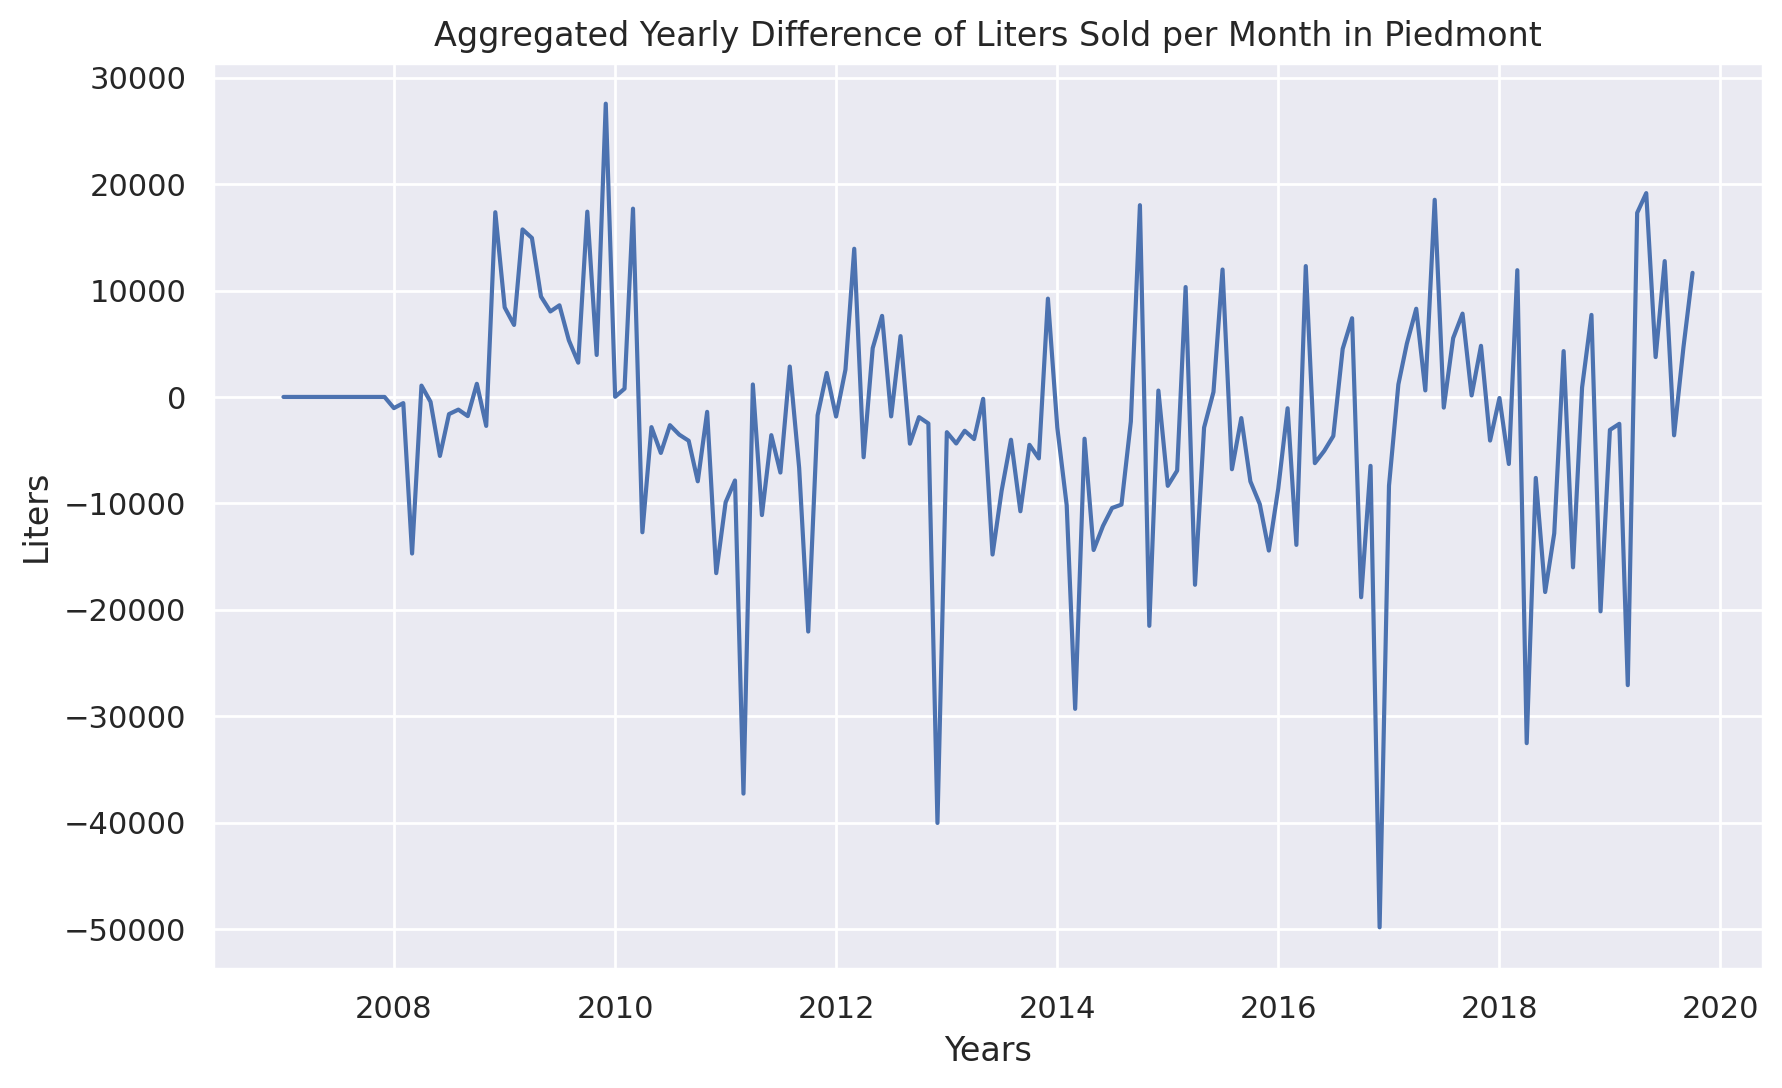

In [26]:
plt.figure(dpi=200)
plt.title('Aggregated Yearly Difference of Liters Sold per Month in Piedmont')
plt.xlabel('Years')
plt.ylabel('Liters')
plt.plot(aggDiff)
plt.savefig("aggDiffPiedmont.png")
files.download("aggDiffPiedmont.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

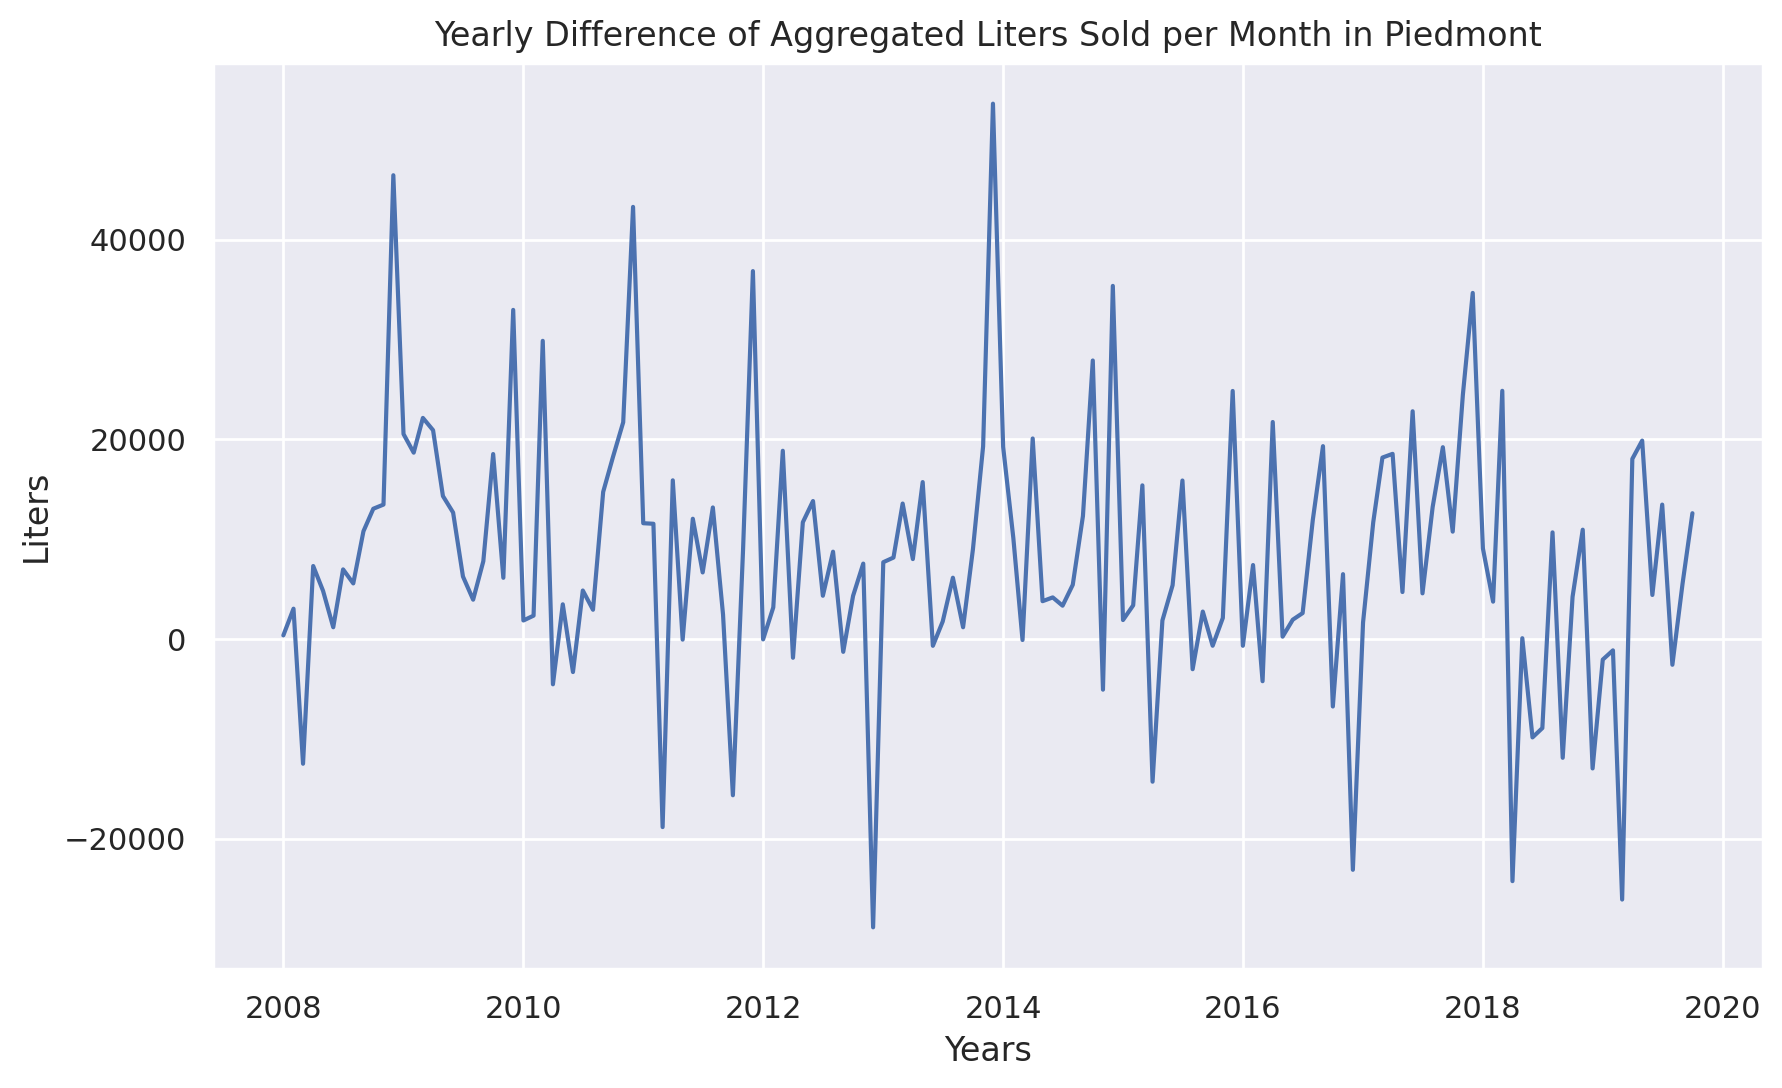

In [21]:
plt.figure(dpi=200)
plt.title('Yearly Difference of Aggregated Liters Sold per Month in Piedmont')
plt.xlabel('Years')
plt.ylabel('Liters')
plt.plot(diffAgg)
plt.savefig("diffAggPiedmont.png")
files.download("diffAggPiedmont.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

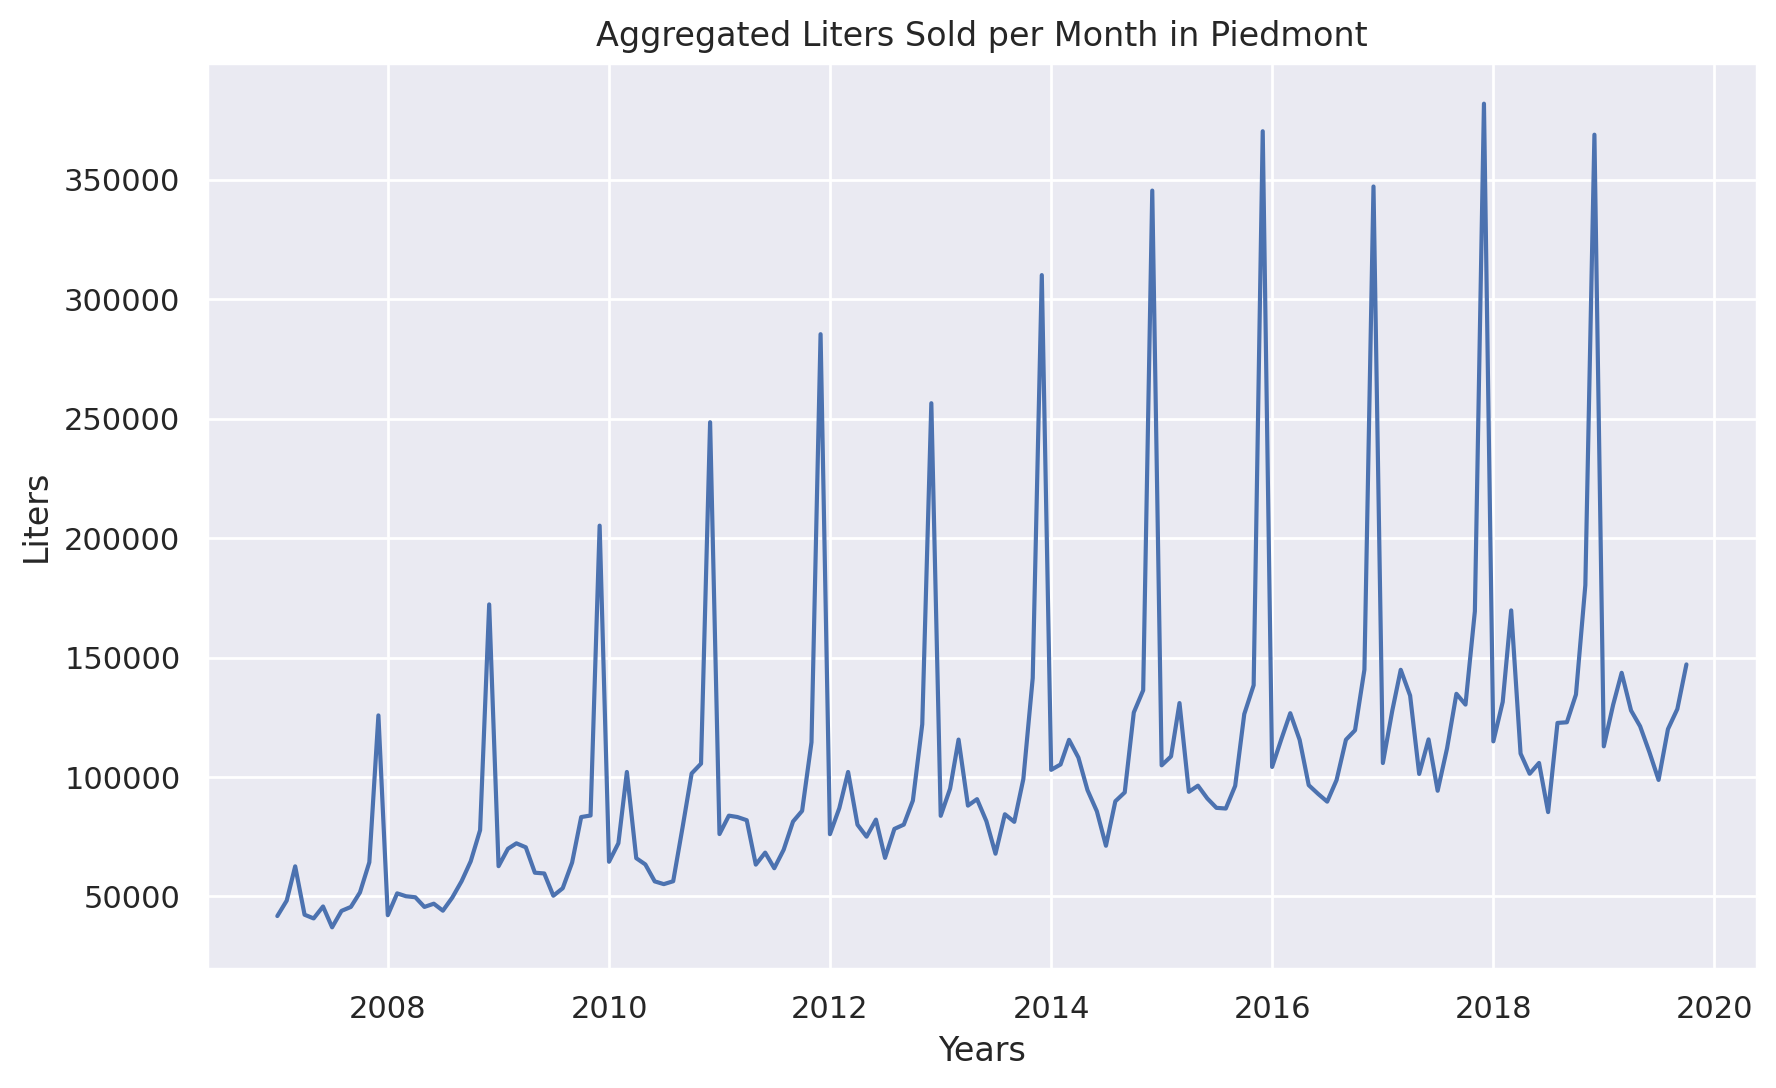

In [22]:
plt.figure(dpi=200)
plt.title('Aggregated Liters Sold per Month in Piedmont')
plt.xlabel('Years')
plt.ylabel('Liters')
plt.plot(aggLiter)
plt.savefig("AggPiedmont.png")
files.download("AggPiedmont.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

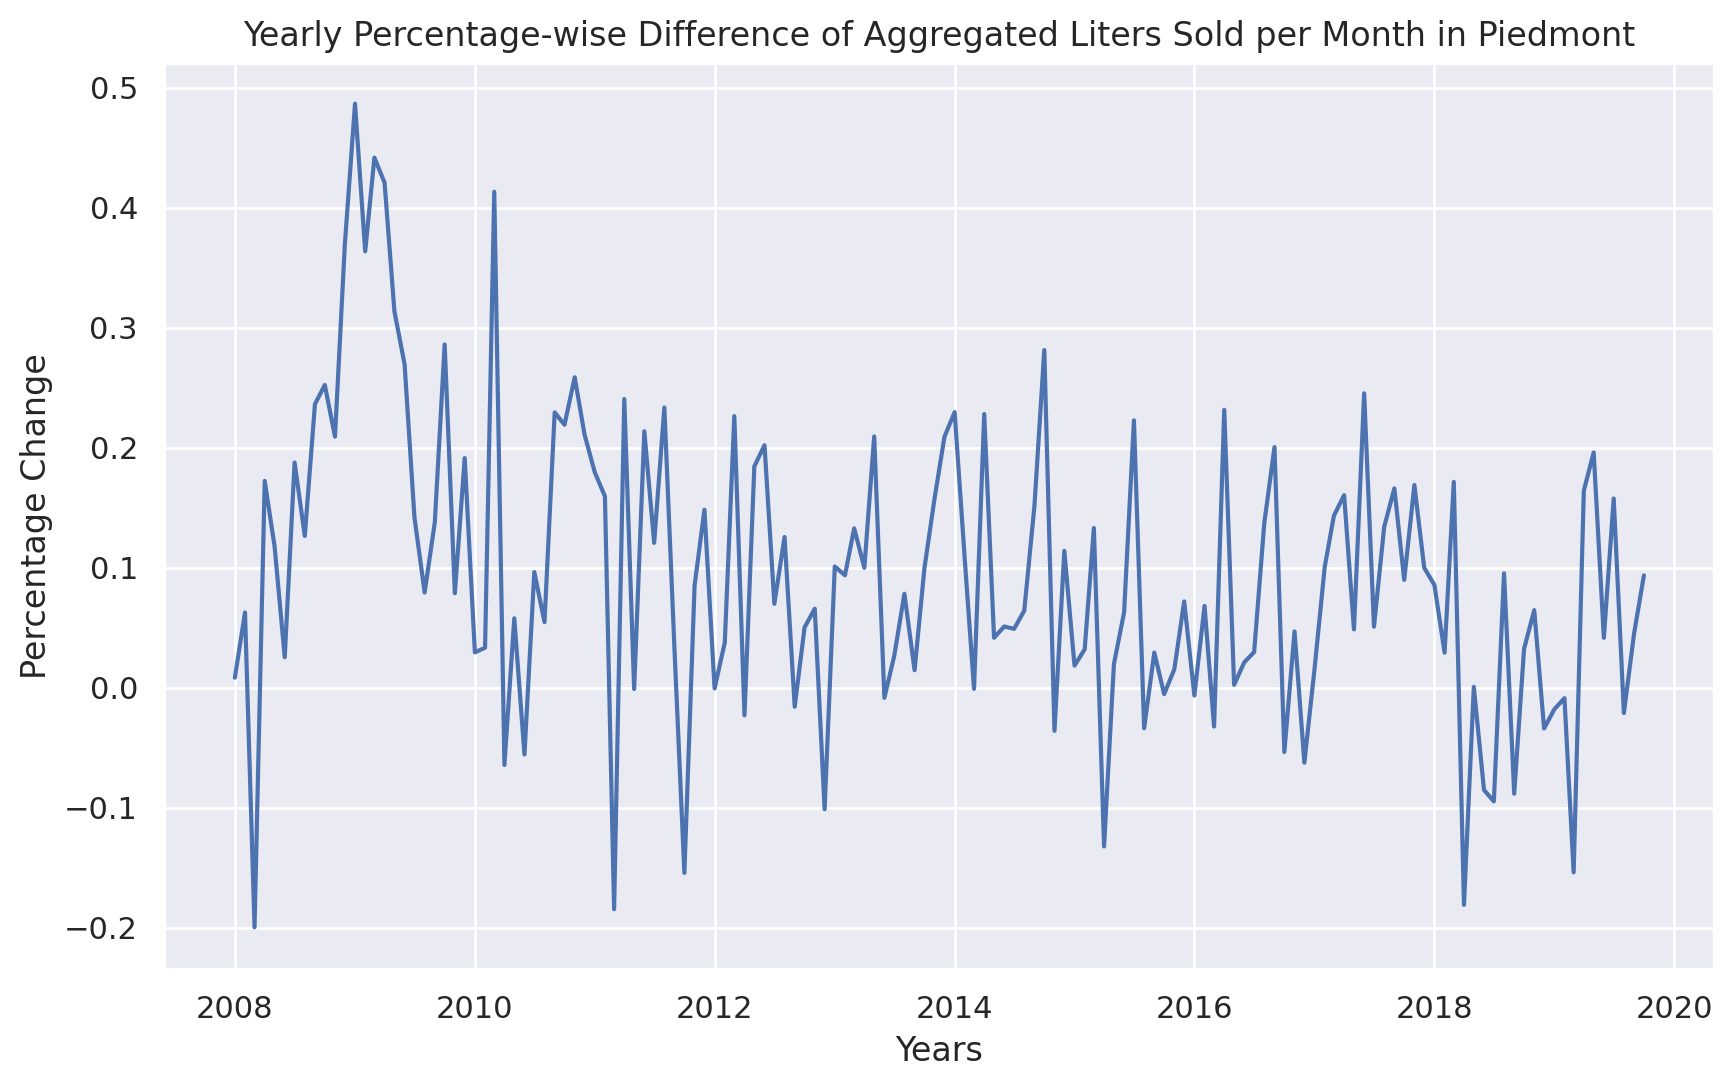

In [23]:
plt.figure(dpi=200)
plt.title('Yearly Percentage-wise Difference of Aggregated Liters Sold per Month in Piedmont')
plt.xlabel('Years')
plt.ylabel('Percentage Change')
plt.plot(pDiffAgg)
plt.savefig("pDiffAggPiedmont.png")
files.download("pDiffAggPiedmont.png")